In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

# Utils

Check [Numpy masked array](https://numpy.org/doc/stable/reference/maskedarray.generic.html)

In [2]:
def read_data(file_prefix, num_data):    
    max_len = 0
    accu_list, loss_list, time_list = [], [], []
    
    # Round number starts from 1 (Rename your CSV files)
    for round_number in range(1, num_data+1):
        f = f'{file_prefix}-{round_number}.csv'
        print(f)
        df = pd.read_csv(f, header=None)
        
        # Append data
        accu_list.append(df[1])
        loss_list.append(df[2])
        time_list.append(df[3])
        
        # Check max length
        if df.shape[0] > max_len:
            max_len = df.shape[0]
    
    return max_len, accu_list, loss_list, time_list


def mask_array(num_data, max_len, data_list):
    """Convert data list to numpy masked array"""
    array_masked = np.ma.empty((num_data, max_len))
    array_masked.mask = True
    
    for i in range(num_data):
        array_masked[i, :data_list[i].shape[0]] = np.array(data_list[i])
        
    return array_masked


def calc_average(num_data, max_len, data_list):
    """
    Get average of arrays of unequal length.
    """

    # Mask the data
    data_masked = mask_array(num_data, max_len, data_list)
    
    # Calculate averages
    data_avg = data_masked.mean(axis=0) 
           
    return data_avg

# Pipeline

In [3]:
def pipe(file_prefix, num_data):
    max_len, accu_list, loss_list, time_list = read_data(file_prefix, num_data)
    accu_avg = calc_average(num_data, max_len, accu_list)
    loss_avg = calc_average(num_data, max_len, loss_list)
    time_avg = calc_average(num_data, max_len, time_list)
    return accu_avg, loss_avg, time_avg

# Parameters
- MNIST
- 3 RSUs
- 100 workers
- Learning Rate = 0.001
- Batch Size = 100
- Edge Server range = 50
- Number of gradients to accumulate before cloud and edge aggregations = 10
- Number of Faulty Gradients = 2
- Magnitude of sign-flip attack = 5
    - Faulty layers in gradients are enlarged by 5 times.

# VM Spec (GCP)

Zone: us-east1-b

Image: ubuntu-1804-bionic-v20210623

1. Simulator (1 VM)
    - e2-standard-2 (2 vCPUs, 8 GB memory)

2. Cloud Server (1 VM)
    - e2-standard-2 (2 vCPUs, 8 GB memory)

3. Edge Servers (1 VM)
    - e2-standard-8 (8 vCPUs, 32 GB memory)

4. Workers (2 VMs - 50 workers on each VM)
    - e2-highcpu-32 (32 vCPUs, 32 GB memory)

# 1. SGD simple mean, sign-flip attack

Only 2 runs of results were collected for this setting. Since simple mean aggregation cannot tolerate sign-flip attack, 2 runs should be sufficient.

In [4]:
file_prefix = "mnist-mean-signflip_attack"
num_data = 2

signflip_mean_acc_avg, signflip_mean_loss_avg, signflip_mean_time_avg = pipe(file_prefix, num_data)

mnist-mean-signflip_attack-1.csv
mnist-mean-signflip_attack-2.csv


# 2. SGD marginal median, sign-flip attack

In [5]:
file_prefix = "mnist-marginal_median-signflip_attack"
num_data = 5

signflip_median_acc_avg, signflip_median_loss_avg, signflip_median_time_avg = pipe(file_prefix, num_data)

mnist-marginal_median-signflip_attack-1.csv
mnist-marginal_median-signflip_attack-2.csv
mnist-marginal_median-signflip_attack-3.csv
mnist-marginal_median-signflip_attack-4.csv
mnist-marginal_median-signflip_attack-5.csv


# 3. SGD simple mean, bit-flip attack

In [6]:
file_prefix = "mnist-mean-bitflip_attack"
num_data = 5

bitflip_mean_acc_avg, bitflip_mean_loss_avg, bitflip_mean_time_avg = pipe(file_prefix, num_data)

mnist-mean-bitflip_attack-1.csv
mnist-mean-bitflip_attack-2.csv
mnist-mean-bitflip_attack-3.csv
mnist-mean-bitflip_attack-4.csv
mnist-mean-bitflip_attack-5.csv


# 4. SGD marginal median, bit-flip attack

In [7]:
file_prefix = "mnist-marginal_median-bitflip_attack"
num_data = 5

bitflip_median_acc_avg, bitflip_median_loss_avg, bitflip_median_time_avg = pipe(file_prefix, num_data)

mnist-marginal_median-bitflip_attack-1.csv
mnist-marginal_median-bitflip_attack-2.csv
mnist-marginal_median-bitflip_attack-3.csv
mnist-marginal_median-bitflip_attack-4.csv
mnist-marginal_median-bitflip_attack-5.csv


# PLOT

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


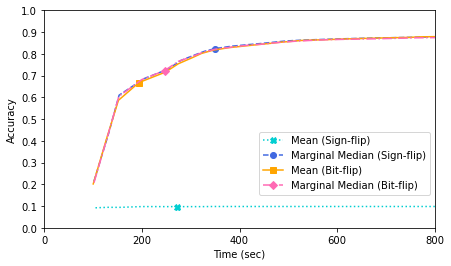

In [20]:
plt.figure(figsize=(7, 4))

plt.plot(signflip_mean_time_avg, signflip_mean_acc_avg, linestyle='dotted', c='darkturquoise')
plt.plot(signflip_mean_time_avg[5], signflip_mean_acc_avg[5], 'X', linestyle='dotted', label="Mean (Sign-flip) ", c='darkturquoise')

plt.plot(signflip_median_time_avg, signflip_median_acc_avg, linestyle='--', c='royalblue')
plt.plot(signflip_median_time_avg[8], signflip_median_acc_avg[8], '--o', label="Marginal Median (Sign-flip)", c='royalblue')

plt.plot(bitflip_mean_time_avg, bitflip_mean_acc_avg, linestyle='-', c='orange')
plt.plot(bitflip_mean_time_avg[3], bitflip_mean_acc_avg[3], '-s', label="Mean (Bit-flip)", c='orange')

plt.plot(bitflip_median_time_avg, bitflip_median_acc_avg, linestyle='-.', c='hotpink')
plt.plot(bitflip_median_time_avg[4], bitflip_median_acc_avg[4], '-.D', label="Marginal Median (Bit-flip)", c='hotpink')

X_LIM = 800
plt.xlim(0, X_LIM)
plt.ylim(bottom=0, top=1)
plt.xticks(np.arange(0, X_LIM+100, 200))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc=4, bbox_to_anchor=(1, 0.13))
plt.xlabel('Time (sec)')
plt.ylabel("Accuracy")
plt.savefig("attack_effect.eps", format='eps')
plt.show()